# Preliminaries

In [11]:
import matplotlib.pyplot as plt
import numpy as np

import utils
import data_utils

# Compute pairwise predictions

## SimpleNN

In [2]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


In [3]:
import torch

def get_predictions(model, test_loader, compute_probabilities=True):
    inpts, targets, predictions, logits = [], [], [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            lgts = outputs
            if compute_probabilities:
                lgts = torch.nn.functional.log_softmax(outputs, dim=1)

            max, predicted = torch.max(lgts, 1)

            inpts.extend(inputs)
            targets.extend(labels.detach())
            predictions.extend(predicted.detach())
            logits.extend(max)  #TODO beware of the fact that the logits in the case of SimpleNN are not actual logits!

            print(max[0], predicted[0], max[0]+predicted[0])

    return inpts, targets, predictions, logits

In [4]:
# load dataloaders
utils.set_seed(0)
train_loaders, test_loaders = data_utils.create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

test_loader_1 = test_loaders[1]
print('rotation_1', test_loader_1['rot'])
test_loader_2 = test_loaders[2]
print('rotation_2', test_loader_2['rot'])

# load model
model_path = '0_SeparateModel/SimpleNN/SeparateModel_{}_{}deg_MNIST.pth'.format(
    config['model_name'],
    test_loader_1['rot']
    )
model = utils.load_model(path=model_path)

# compute predictions
inputs_1, targets_1, predictions_1, logits_1 = get_predictions(model, test_loader_1['loader'])
inputs_2, targets_2, predictions_2, logits_2 = get_predictions(model, test_loader_2['loader'])

Random seed set as 0
rotation_1 0
rotation_2 45
tensor(-8.1062e-06) tensor(7) tensor(7.0000)
tensor(-1.8954e-05) tensor(2) tensor(2.0000)
tensor(-4.7684e-07) tensor(2) tensor(2.0000)
tensor(-9.6559e-06) tensor(1) tensor(1.0000)
tensor(-0.0102) tensor(4) tensor(3.9898)
tensor(-0.0003) tensor(1) tensor(0.9997)
tensor(-0.0005) tensor(6) tensor(5.9995)
tensor(-2.8133e-05) tensor(7) tensor(7.0000)
tensor(-0.0002) tensor(7) tensor(6.9998)
tensor(-4.6729e-05) tensor(0) tensor(-4.6729e-05)
tensor(-0.0170) tensor(3) tensor(2.9830)
tensor(-0.0002) tensor(1) tensor(0.9998)
tensor(-2.0146e-05) tensor(8) tensor(8.0000)
tensor(-0.0005) tensor(7) tensor(6.9995)
tensor(0.) tensor(0) tensor(0.)
tensor(-1.4186e-05) tensor(9) tensor(9.0000)
tensor(-0.0041) tensor(8) tensor(7.9959)
tensor(-2.3246e-05) tensor(3) tensor(3.0000)
tensor(-0.0004) tensor(8) tensor(7.9996)
tensor(-0.0004) tensor(1) tensor(0.9996)
tensor(-2.3842e-07) tensor(2) tensor(2.0000)
tensor(-1.0967e-05) tensor(8) tensor(8.0000)
tensor(-3.

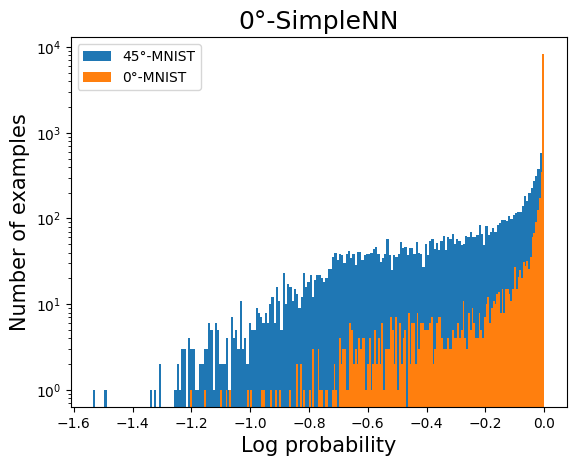

In [7]:
plt.hist(logits_2, bins=200, label='45°-MNIST')
plt.hist(logits_1, bins=200, label='0°-MNIST')

plt.title('0°-SimpleNN', fontsize=18)
plt.ylabel('Number of examples', fontsize=15)
plt.xlabel('Log probability', fontsize=15)
plt.yscale('log')
plt.legend()
plt.savefig('0_SeparateModel/SeparateModel_SimpleNN_-0deg_log_probabilities_comparison_0deg_vs_45deg.pdf')
plt.show()

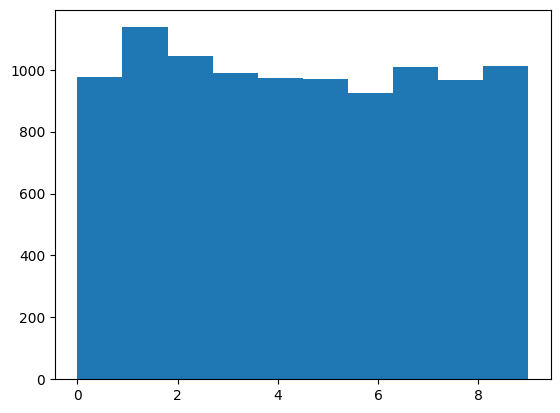

In [8]:
plt.hist(predictions_1)
plt.show()

In [9]:
assert targets_1 == targets_2  # because `shuffle` is set to `False` in `test_loader`

In [10]:
print(len(targets_1))

10000


In [13]:
m1 = np.array(targets_1)==np.array(predictions_1)
m2 = np.array(targets_2)==np.array(predictions_2)

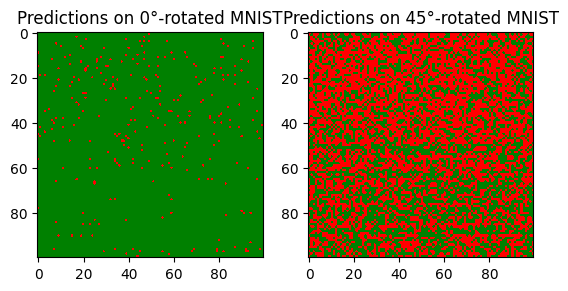

In [14]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1, 2)

cmap = ListedColormap(['red', 'green'])

#ax[0].pcolormesh(m1.reshape(100, 100), cmap=cmap, edgecolors='white', linewidth=0.005)
ax[0].imshow(m1.reshape((100, 100)), cmap=cmap)
ax[0].set_title('Predictions on {}°-rotated MNIST'.format(0))

ax[1].imshow(m2.reshape((100, 100)), cmap=cmap)
ax[1].set_title('Predictions on {}°-rotated MNIST'.format(45))
#ax[1].grid(color='w', linewidth=2)

#fig.suptitle('(green) Correctly vs (red) Wrongly predicted examples - model trained on {}°-rotated MNIST'.format(0))
plt.savefig('0_SeparateModel/{}_{}_overall_predictions_{}deg-mnist_vs_{}deg-mnist.pdf'.format(
    config['setting'],
    config['model_name'],
    0,
    45
), bbox_inches='tight')
plt.show()

<BarContainer object of 10 artists>

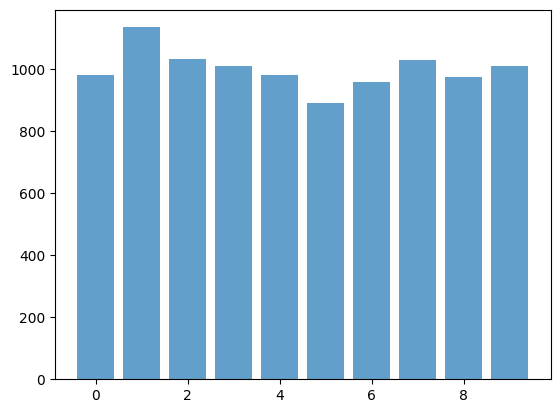

In [15]:
labels = [label for label in targets_1]
unique_labels, counts = torch.unique(torch.tensor(labels), return_counts=True)

plt.bar(unique_labels, counts, align='center', alpha=0.7)

### tests on probabilities (after `torch.nn.functional.log_softmax(outputs, dim=1)`)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == "":


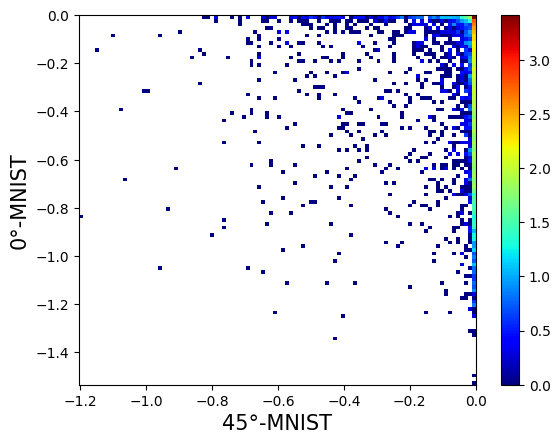

In [16]:
H, xedges, yedges = np.histogram2d(np.array(logits_1),np.array(logits_2),bins=100) #,range=histRange)
#H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
#print(xedges, yedges)

# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
# Log
Hmasked = np.log10(Hmasked)     

# Plot 2D histogram using pcolor
fig2 = plt.figure()
#plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.colorbar()
#plt.xticks(range(0,20,200), range(10))
#plt.yticks(range(10))

plt.title('')
plt.ylabel('0°-MNIST', fontsize=15)
plt.xlabel('45°-MNIST', fontsize=15)
path = '0_SeparateModel/{}_{}_{}deg_logits_{}deg-MNIST_vs_{}deg-MNIST.pdf'.format(
    config['setting'],
    config['model_name'],
    0,
    0,
    45
)
plt.savefig(path)
plt.show()

[ True  True  True ...  True  True  True]
[7 2 1 ... 4 5 6]
(9726,)


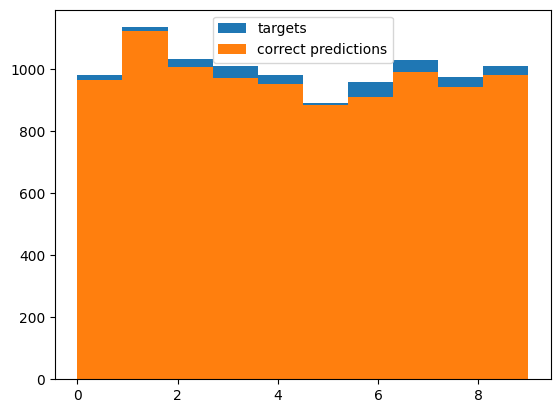

[False False  True ...  True  True  True]
[1 1 9 ... 4 5 6]
(4482,)


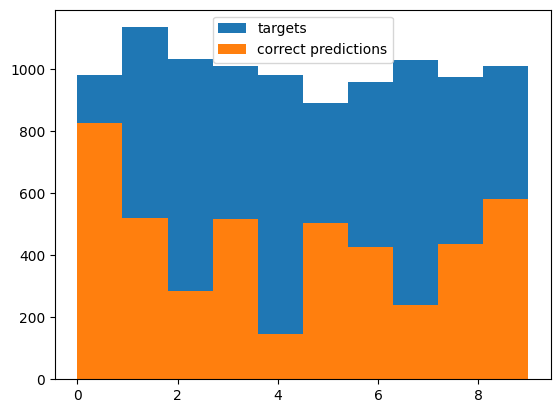

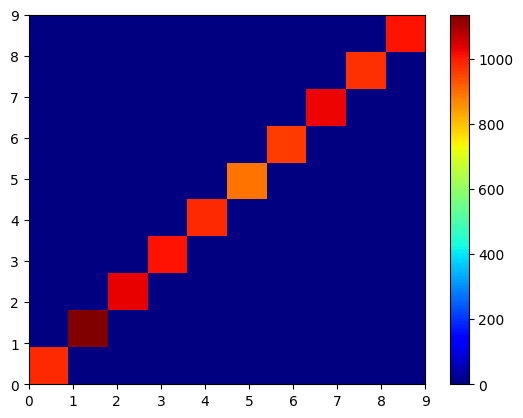

In [17]:
print(m1)
correctly_classified_1 = np.array(targets_1)[m1]
print(correctly_classified_1)
print(correctly_classified_1.shape)

plt.hist(targets_1, bins=10, label='targets')
plt.hist(correctly_classified_1, bins=10, label='correct predictions')
plt.legend()
plt.show()

print(m2)
correctly_classified_2 = np.array(targets_2)[m2]
print(correctly_classified_2)
print(correctly_classified_2.shape)

plt.hist(targets_2, bins=10, label='targets')
plt.hist(correctly_classified_2, bins=10, label='correct predictions')
plt.legend()
plt.show()


plt.hist2d(targets_1, targets_2, bins=10, cmap='jet')
plt.colorbar()
plt.show()

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]
[False False  True ...  True  True  True]
[ True  True False ... False False False]


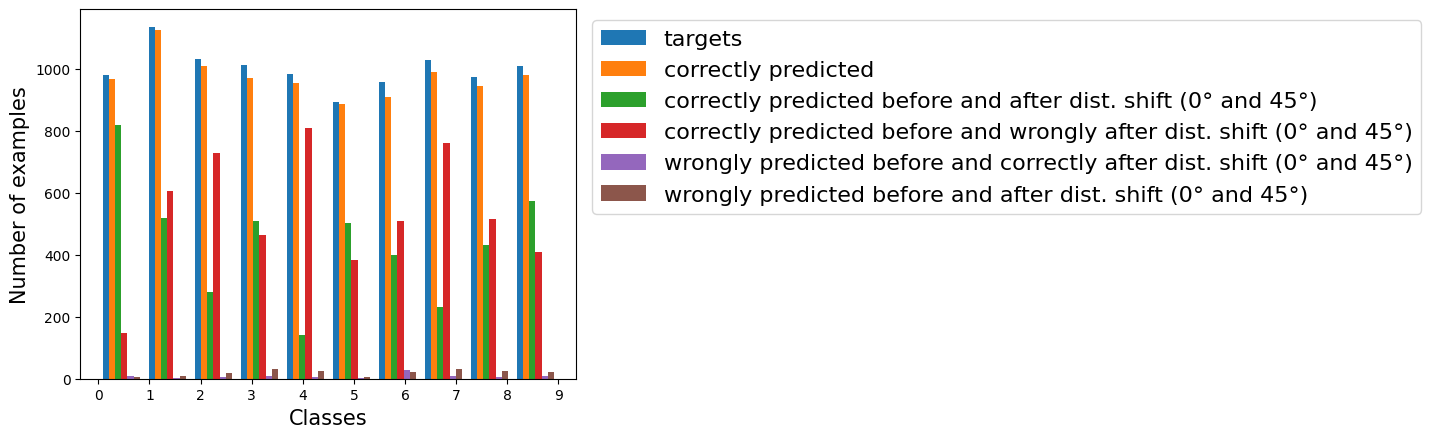

In [18]:
np_targets_1 = np.array(targets_1)
np_targets_2 = np.array(targets_2)
np_preds_1 = np.array(predictions_1)
np_preds_2 = np.array(predictions_2)
np_logits_1 = np.array(logits_1)
np_logits_2 = np.array(logits_2)

print(np_targets_1)
print(np_targets_2)
assert np.all(np.equal(np_targets_1, np_targets_2))

bien_bien_preds = np.logical_and(np_preds_1==np_targets_1, np_preds_2==np_targets_2)
bien_mal_preds = np.logical_and(np_preds_1==np_targets_1, np_preds_2!=np_targets_2)
mal_bien_preds = np.logical_and(np_preds_1!=np_targets_1, np_preds_2==np_targets_2)
mal_mal_preds = np.logical_and(np_preds_1!=np_targets_1, np_preds_2!=np_targets_2)
print(bien_bien_preds)
print(bien_mal_preds)


plt.hist(
        (np_targets_1,
         np_targets_1[m1],
         np_targets_1[bien_bien_preds],
         np_targets_1[bien_mal_preds],
         np_targets_1[mal_bien_preds],
         np_targets_1[mal_mal_preds]),
         bins=10,
         label=('targets',
                'correctly predicted',
                'correctly predicted before and after dist. shift (0° and 45°)',
                'correctly predicted before and wrongly after dist. shift (0° and 45°)',
                'wrongly predicted before and correctly after dist. shift (0° and 45°)',
                'wrongly predicted before and after dist. shift (0° and 45°)')
)
#plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=16)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.xticks(range(10))
plt.savefig('0_SeparateModel/SeparateModel_SimpleNN_0deg_predictions_hist.pdf', bbox_inches='tight')
plt.show()

[False False False ... False False False]


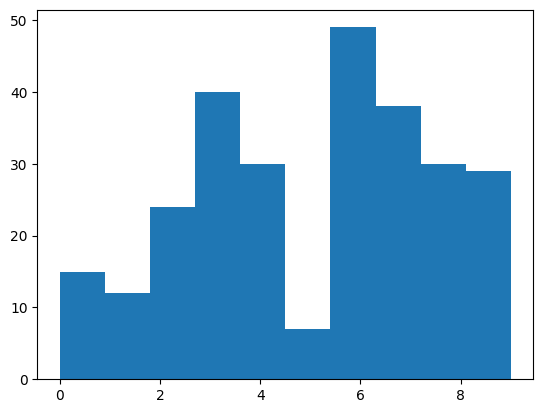

In [19]:
print(bien_bien_preds==bien_mal_preds)
plt.hist(np_targets_1[bien_bien_preds==bien_mal_preds])
plt.show()

#### predictions and logits/probabilities histograms

In [104]:
def plot_hist2d(a, b,
                what,
                ylabel, xlabel,
                bins, cmap,
                deg_in, deg_out,
                vmax=None, xlim=None, ylim=None,
                log=False,
                config=None):
    H, xedges, yedges = np.histogram2d(a,b,bins=bins) #,range=histRange)
    #H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
    #print(xedges, yedges)

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)
    
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    # Log
    if log is True:
        Hmasked = np.log10(Hmasked)     

    # Plot 2D histogram using pcolor
    fig2 = plt.figure()
    #plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
    plt.pcolormesh(xedges,yedges,Hmasked, cmap=cmap, vmin=0, vmax=vmax)
    plt.colorbar()
    #plt.xticks(range(0,20,200), range(10))
    #plt.yticks(range(10))

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.title('{}°-SimpleNN model'.format(deg_in), fontsize=18)
    plt.ylabel('({}°-MNIST) {}'.format(deg_out, ylabel), fontsize=15)
    plt.xlabel('({}°-MNIST) {}'.format(deg_in, xlabel), fontsize=15)
    #path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_how-correct-preds-in-{}deg-MNIST-are-classified-in-{}deg-MNIST.pdf'.format(
    path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_{}_{}deg_in_{}deg_out.pdf'.format(
        deg_in,
        what,
        deg_in,
        deg_out 
    )
    plt.savefig(path,bbox_inches='tight')
    plt.show()

##### predictions histograms

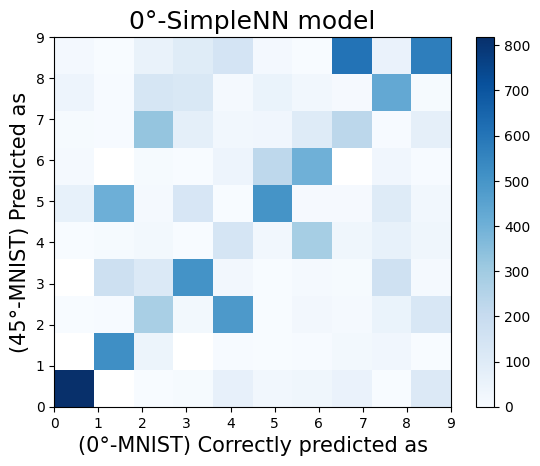

In [87]:
# 1. Take all the correctly classified examples in 0°-MNIST
# 2. Then, look how they have been predicted in the case of 45°-MNIST
a = np_preds_1[m1]  # correctly classified examples in 0°-MNIST
b = np_preds_2[m1]  # how the correctly predicted examples in 0°-MNIST are predicted when they are rotated by 45°

assert a.shape==b.shape

#bien: correctly predicted
#how: how they are predicted
plot_hist2d(a, b,
            what='bien_how_preds',
            xlabel='Correctly predicted as', ylabel='Predicted as',
            bins=10, cmap='Blues',
            deg_in=0, deg_out=45,
            log=False,
            config=None)

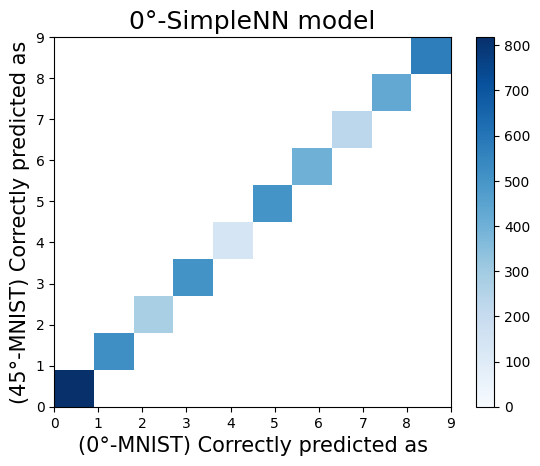

In [79]:
a = np_preds_1[bien_bien_preds]  # how correctly predicted examples in 0°-MNIST
b = np_preds_2[bien_bien_preds]  # how the correctly predicted examples in 0°-MNIST are correctly predicted when they are rotated by 45°
# it's useless, but is here (to stay!)

assert a.shape==b.shape

plot_hist2d(a, b,
            what='bien_bien_preds',
            bins=10,
            xlabel='Correctly predicted as', ylabel='Correctly predicted as',
            cmap='Blues',
            deg_in=0, deg_out=45,
            log=False,
            config=None)

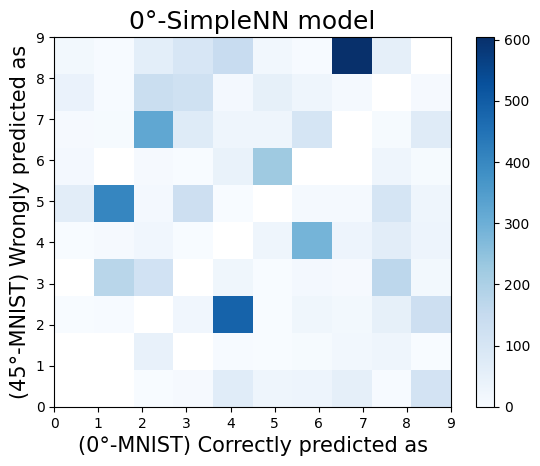

In [80]:
a = np_preds_1[bien_mal_preds]  # how correctly predicted examples in 0°-MNIST
b = np_preds_2[bien_mal_preds]  # how the correctly predicted examples in 0°-MNIST are wrongly predicted when they are rotated by 45°

assert a.shape==b.shape

plot_hist2d(a, b,
            what='bien_mal_preds',
            xlabel='Correctly predicted as', ylabel='Wrongly predicted as',
            bins=10, cmap='Blues',
            deg_in=0, deg_out=45,
            log=False,
            config=None)

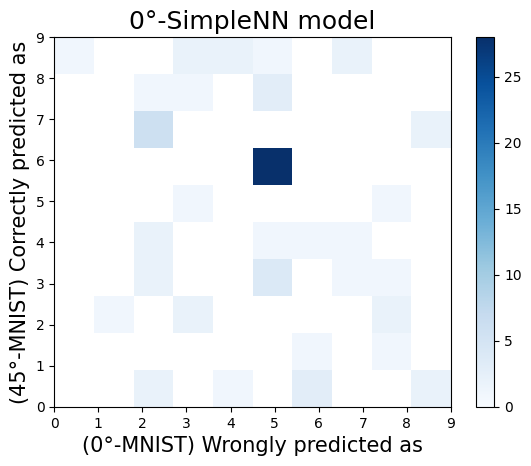

In [81]:
a = np_preds_1[mal_bien_preds]  # how wrongly predicted examples in 0°-MNIST
b = np_preds_2[mal_bien_preds]  # how the wrongly predicted examples in 0°-MNIST are correctly predicted when they are rotated by 45°

assert a.shape==b.shape

plot_hist2d(a, b,
            what='mal_bien_preds',
            xlabel='Wrongly predicted as', ylabel='Correctly predicted as',
            bins=10, cmap='Blues',
            deg_in=0, deg_out=45,
            log=False,
            config=None)

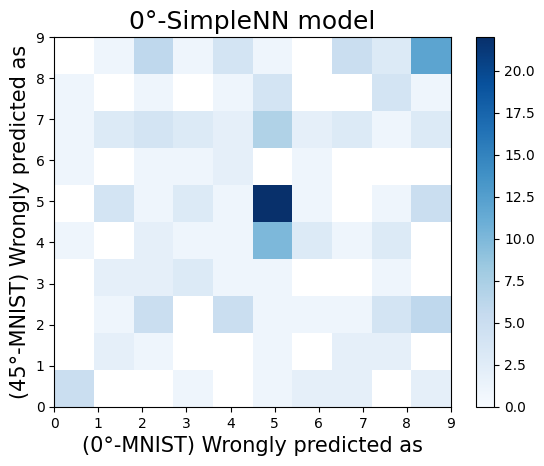

In [82]:
a = np_preds_1[mal_mal_preds]  # how wrongly predicted examples in 0°-MNIST
b = np_preds_2[mal_mal_preds]  # how the correctly predicted examples in 0°-MNIST are predicted when they are rotated by 45°

assert a.shape==b.shape

plot_hist2d(a, b,
            what='mal_mal_preds',
            xlabel='Wrongly predicted as', ylabel='Wrongly predicted as',
            bins=10, cmap='Blues',
            deg_in=0, deg_out=45,
            log=False,
            config=None)

##### logits/probabilities histograms

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


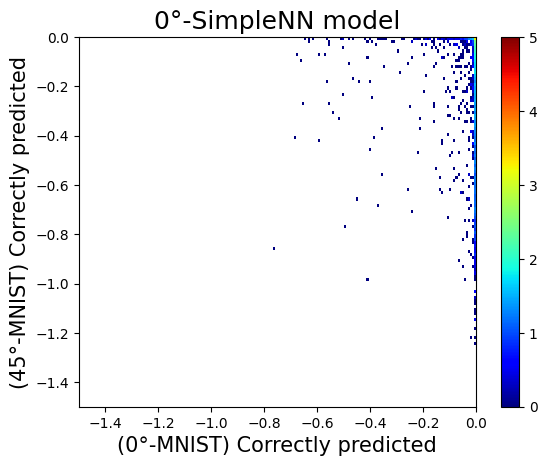

In [105]:
a = np.array(logits_1)[bien_bien_preds]
b = np.array(logits_2)[bien_bien_preds]

assert a.shape==b.shape

plot_hist2d(a, b,
            what='bien_bien_preds_logits',
            xlabel='Correctly predicted', ylabel='Correctly predicted',
            bins=100, cmap='jet',
            vmax=5, xlim=[-1.5, 0], ylim=[-1.5, 0],
            deg_in=0, deg_out=45,
            log=True,
            config=None)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


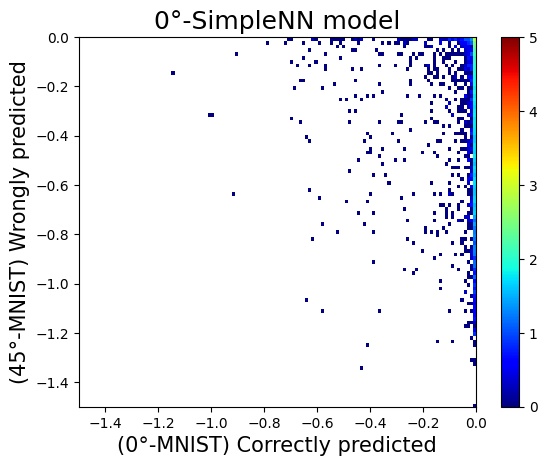

In [106]:
a = np.array(logits_1)[bien_mal_preds]
b = np.array(logits_2)[bien_mal_preds]

assert a.shape==b.shape

plot_hist2d(a, b,
            what='bien_mal_preds_logits',
            xlabel='Correctly predicted', ylabel='Wrongly predicted',
            bins=100, cmap='jet',
            vmax=5, xlim=[-1.5, 0], ylim=[-1.5, 0],
            deg_in=0, deg_out=45,
            log=True,
            config=None)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


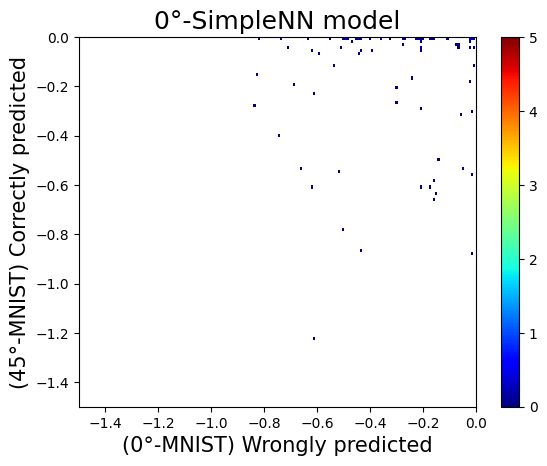

In [107]:
a = np.array(logits_1)[mal_bien_preds]
b = np.array(logits_2)[mal_bien_preds]

assert a.shape==b.shape

plot_hist2d(a, b,
            what='mal_bien_preds_logits',
            xlabel='Wrongly predicted', ylabel='Correctly predicted',
            bins=100, cmap='jet',
            vmax=5, xlim=[-1.5, 0], ylim=[-1.5, 0],
            deg_in=0, deg_out=45,
            log=True,
            config=None)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


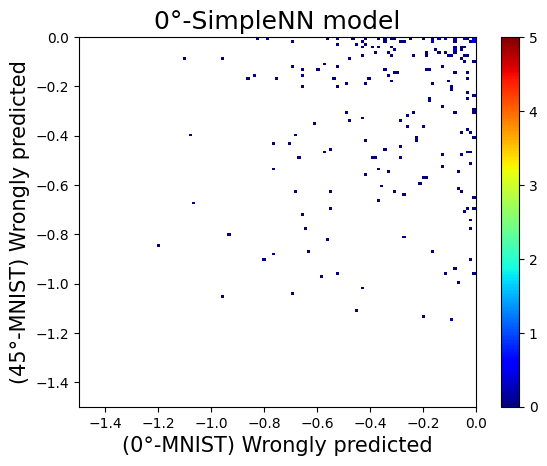

In [108]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape

plot_hist2d(a, b,
            what='mal_mal_preds_logits',
            bins=100,
            xlabel='Wrongly predicted', ylabel='Wrongly predicted',
            cmap='jet', vmax=5, xlim=[-1.5, 0], ylim=[-1.5, 0],
            deg_in=0, deg_out=45,
            log=True,
            config=None)

## Visualizing examples depending on the model's predictions

### logits/probabilities histograms with MNIST input examples

In [118]:
def plot_mnist_examples(
    what,
    mask,
    inputs_1, np_targets_1, np_logits_1, np_preds_1,
    inputs_2, np_targets_2, np_logits_2, np_preds_2,
    xcadrillage, ycadrillage,
    xlabel='Correctly predicted', ylabel='Wrongly predicted',
    #xlim=None, ylim=None,
    bins=100,
    cmap='jet', vmax=5, xlim=[-1.5, 0], ylim=[-1.5, 0],
    deg_in=0, deg_out=45, log=False,
    config=None
    ):

    a = np_logits_1[mask]
    b = np_logits_2[mask]

    print(a.shape)
    assert a.shape==b.shape

    H, xedges, yedges = np.histogram2d(a,b,bins=bins) #,range=histRange)
    #H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
    with np.printoptions(threshold=np.inf):
        #print(list(zip(mask, np_logits_1, np_logits_2)))
        print(xedges, yedges)
        print(H[:50, :50])

    # H (is in a y,x format) needs to be rotated and flipped (in order to match the x,y referential of pcolormesh)
    H = np.rot90(H)
    H = np.flipud(H)
    
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    # Log
    if log is True:
        Hmasked = np.log10(Hmasked)     

    # Plot 2D histogram using pcolor
    fig2 = plt.figure()
    #plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
    plt.pcolormesh(xedges,yedges,Hmasked, cmap=cmap) #, vmin=0, vmax=vmax)
    plt.colorbar()
    #plt.xticks(range(0,20,200), range(10))
    #plt.yticks(range(10))

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    rect = plt.Rectangle((xedges[xcadrillage], yedges[ycadrillage]), xlim[0]-xedges[xcadrillage], ylim[0]-yedges[ycadrillage],  #(left, bottom), width, height,
                         facecolor="black", alpha=0.1)

    plt.gca().add_patch(rect)  #ax.add_patch(rect)

    # Cadrillage
    plt.axhline(y=yedges[ycadrillage], linestyle='--', linewidth=1, color='grey')
    plt.axvline(x=xedges[xcadrillage], linestyle='--', linewidth=1, color='grey')

    plt.title('{}°-SimpleNN model'.format(deg_in), fontsize=18)
    plt.ylabel('({}°-MNIST) {}'.format(deg_out, ylabel), fontsize=15)
    plt.xlabel('({}°-MNIST) {}'.format(deg_in, xlabel), fontsize=15)

    path = '0_SeparateModel/{}_{}_{}deg_{}_{}deg_in_{}deg_out_WITH_CADRILLAGE.pdf'.format(
        config['setting'],
        config['model_name'],
        deg_in,
        what,
        deg_in,
        deg_out 
    )
    plt.savefig(path,bbox_inches='tight')


    ############################################### second part of the plot
    print(xedges[xcadrillage])
    print(yedges[ycadrillage])
    #cond_1 = (np_logits_1 <= yedges[ycadrillage]) & mask
    #cond_2 = (np_logits_2 <= xedges[xcadrillage]) & mask
    cond_1 = (np_logits_1 <= xedges[xcadrillage]) & (np_logits_2 <= yedges[ycadrillage]) & mask

    print(np_targets_1[cond_1])
    print(np_preds_2[cond_1])
    print(np_preds_2[cond_1].shape[0])

    num_images = min(5, np_preds_2[cond_1].shape[0])
    #plt.figure(figsize=(15, 3))
    fig, ax = plt.subplots(nrows=2, ncols=num_images, figsize=(num_images*2, 2*2))

    rng = np.random.default_rng()
    images_and_labels = rng.choice(
        list(zip(
            np.array(inputs_1, dtype=object)[cond_1], np_preds_1[cond_1], np_logits_1[cond_1],
            np.array(inputs_2, dtype=object)[cond_1], np_preds_2[cond_1], np_logits_2[cond_1],
            #np.array(inputs_1, dtype=object)[cond_2], np.array(preds_1, dtype=object)[cond_2], np.array(logits_1, dtype=object)[cond_2],
            #np.array(inputs_2, dtype=object)[cond_2], np.array(preds_2, dtype=object)[cond_2], np.array(logits_2, dtype=object)[cond_2]
            )),
        size=num_images, replace=False)

    for i in range(num_images):
        img1, pred1, logit1, img2, pred2, logit2 = images_and_labels[i]  #,\
            #img1_2, pred1_2, logit1_2, img2_2, pred2_2, logit2_2 = images_and_labels[i]

        #plt.subplot(1, num_images, i+1)
        ax[0, i].imshow(img1[0], cmap='gray')
        ax[0, i].set_title(f'predicted: {pred1}\n proba: {logit1:.3f}')
        ax[0, i].axis('off')

        #plt.subplot(2, num_images, i+1)
        ax[1, i].imshow(img2[0], cmap='gray')
        ax[1, i].set_title(f'predicted: {pred2}\n proba: {logit2:.3f}')
        ax[1, i].axis('off')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

    path = '0_SeparateModel/{}_{}_{}deg_{}_{}deg_in_{}deg_out_WITH_IMAGES.pdf'.format(
        config['setting'],
        config['model_name'],
        deg_in,
        what,
        deg_in,
        deg_out 
    )
    plt.savefig(path,bbox_inches='tight')
    plt.show()


(4403,)
[-0.76455605 -0.75691049 -0.74926493 -0.74161937 -0.73397381 -0.72632825
 -0.71868269 -0.71103713 -0.70339157 -0.69574601 -0.68810045 -0.68045488
 -0.67280932 -0.66516376 -0.6575182  -0.64987264 -0.64222708 -0.63458152
 -0.62693596 -0.6192904  -0.61164484 -0.60399928 -0.59635372 -0.58870816
 -0.5810626  -0.57341704 -0.56577148 -0.55812592 -0.55048036 -0.5428348
 -0.53518924 -0.52754367 -0.51989811 -0.51225255 -0.50460699 -0.49696143
 -0.48931587 -0.48167031 -0.47402475 -0.46637919 -0.45873363 -0.45108807
 -0.44344251 -0.43579695 -0.42815139 -0.42050583 -0.41286027 -0.40521471
 -0.39756915 -0.38992359 -0.38227803 -0.37463246 -0.3669869  -0.35934134
 -0.35169578 -0.34405022 -0.33640466 -0.3287591  -0.32111354 -0.31346798
 -0.30582242 -0.29817686 -0.2905313  -0.28288574 -0.27524018 -0.26759462
 -0.25994906 -0.2523035  -0.24465794 -0.23701238 -0.22936682 -0.22172125
 -0.21407569 -0.20643013 -0.19878457 -0.19113901 -0.18349345 -0.17584789
 -0.16820233 -0.16055677 -0.15291121 -0.1452

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:93: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you

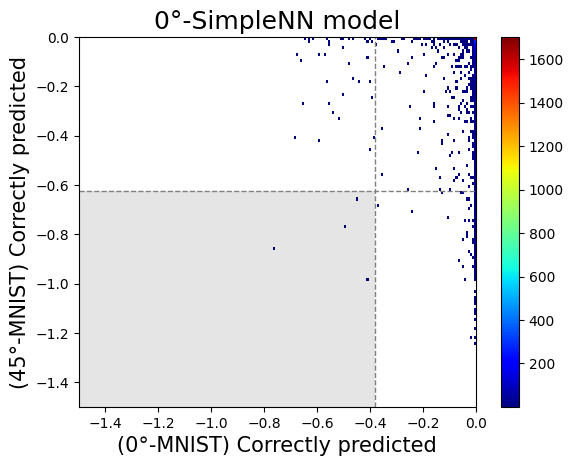

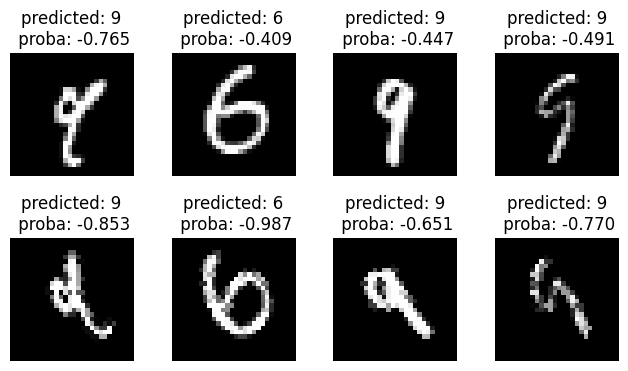

In [114]:
plot_mnist_examples(
    mask=bien_bien_preds,
    inputs_1=inputs_1, np_targets_1=np_targets_1, np_logits_1=np_logits_1, np_preds_1=np_preds_1,
    inputs_2=inputs_2, np_targets_2=np_targets_2, np_logits_2=np_logits_2, np_preds_2=np_preds_2,
    xcadrillage=50, ycadrillage=50,
    what='bien_bien_preds_logits',
    xlabel='Correctly predicted', ylabel='Correctly predicted',
    config=config)


(5323,)
[-1.15004373 -1.13854329 -1.12704285 -1.11554241 -1.10404198 -1.09254154
 -1.0810411  -1.06954067 -1.05804023 -1.04653979 -1.03503935 -1.02353892
 -1.01203848 -1.00053804 -0.9890376  -0.97753717 -0.96603673 -0.95453629
 -0.94303586 -0.93153542 -0.92003498 -0.90853454 -0.89703411 -0.88553367
 -0.87403323 -0.86253279 -0.85103236 -0.83953192 -0.82803148 -0.81653105
 -0.80503061 -0.79353017 -0.78202973 -0.7705293  -0.75902886 -0.74752842
 -0.73602798 -0.72452755 -0.71302711 -0.70152667 -0.69002624 -0.6785258
 -0.66702536 -0.65552492 -0.64402449 -0.63252405 -0.62102361 -0.60952317
 -0.59802274 -0.5865223  -0.57502186 -0.56352143 -0.55202099 -0.54052055
 -0.52902011 -0.51751968 -0.50601924 -0.4945188  -0.48301836 -0.47151793
 -0.46001749 -0.44851705 -0.43701662 -0.42551618 -0.41401574 -0.4025153
 -0.39101487 -0.37951443 -0.36801399 -0.35651356 -0.34501312 -0.33351268
 -0.32201224 -0.31051181 -0.29901137 -0.28751093 -0.27601049 -0.26451006
 -0.25300962 -0.24150918 -0.23000875 -0.21850

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:93: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you

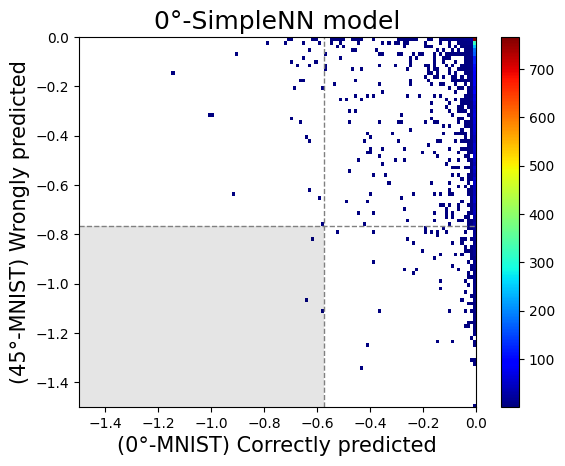

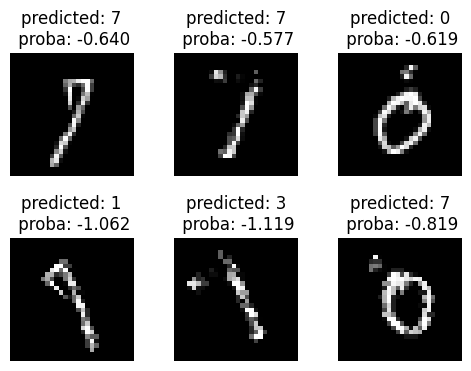

In [115]:
plot_mnist_examples(
    mask=bien_mal_preds,
    inputs_1=inputs_1, np_targets_1=np_targets_1, np_logits_1=np_logits_1, np_preds_1=np_preds_1,
    inputs_2=inputs_2, np_targets_2=np_targets_2, np_logits_2=np_logits_2, np_preds_2=np_preds_2,
    xcadrillage=50, ycadrillage=50,
    what='bien_mal_preds_logits',
    xlabel='Correctly predicted', ylabel='Wrongly predicted',
    config=config)


(79,)
[-0.84066087 -0.83227428 -0.82388769 -0.8155011  -0.80711452 -0.79872793
 -0.79034134 -0.78195475 -0.77356816 -0.76518157 -0.75679499 -0.7484084
 -0.74002181 -0.73163522 -0.72324863 -0.71486204 -0.70647545 -0.69808887
 -0.68970228 -0.68131569 -0.6729291  -0.66454251 -0.65615592 -0.64776934
 -0.63938275 -0.63099616 -0.62260957 -0.61422298 -0.60583639 -0.5974498
 -0.58906322 -0.58067663 -0.57229004 -0.56390345 -0.55551686 -0.54713027
 -0.53874368 -0.5303571  -0.52197051 -0.51358392 -0.50519733 -0.49681074
 -0.48842415 -0.48003757 -0.47165098 -0.46326439 -0.4548778  -0.44649121
 -0.43810462 -0.42971803 -0.42133145 -0.41294486 -0.40455827 -0.39617168
 -0.38778509 -0.3793985  -0.37101192 -0.36262533 -0.35423874 -0.34585215
 -0.33746556 -0.32907897 -0.32069238 -0.3123058  -0.30391921 -0.29553262
 -0.28714603 -0.27875944 -0.27037285 -0.26198626 -0.25359968 -0.24521309
 -0.2368265  -0.22843991 -0.22005332 -0.21166673 -0.20328015 -0.19489356
 -0.18650697 -0.17812038 -0.16973379 -0.1613472

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:93: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you

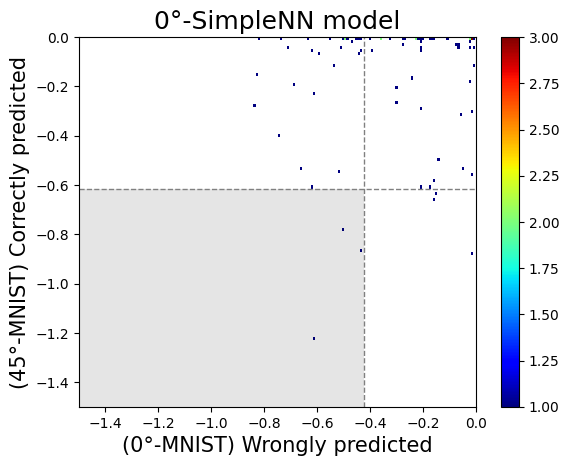

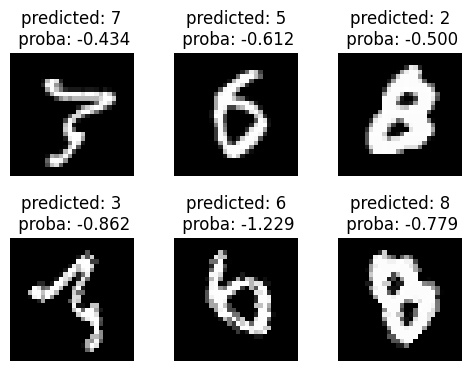

In [116]:
plot_mnist_examples(
    mask=mal_bien_preds,
    inputs_1=inputs_1, np_targets_1=np_targets_1, np_logits_1=np_logits_1, np_preds_1=np_preds_1,
    inputs_2=inputs_2, np_targets_2=np_targets_2, np_logits_2=np_logits_2, np_preds_2=np_preds_2,
    xcadrillage=50, ycadrillage=50,
    what='mal_bien_preds_logits',
    xlabel='Wrongly predicted', ylabel='Correctly predicted',
    config=config)


(195,)
[-1.20373380e+00 -1.19169824e+00 -1.17966268e+00 -1.16762712e+00
 -1.15559156e+00 -1.14355600e+00 -1.13152044e+00 -1.11948488e+00
 -1.10744933e+00 -1.09541377e+00 -1.08337821e+00 -1.07134265e+00
 -1.05930709e+00 -1.04727153e+00 -1.03523597e+00 -1.02320041e+00
 -1.01116485e+00 -9.99129289e-01 -9.87093730e-01 -9.75058170e-01
 -9.63022610e-01 -9.50987051e-01 -9.38951491e-01 -9.26915932e-01
 -9.14880372e-01 -9.02844812e-01 -8.90809253e-01 -8.78773693e-01
 -8.66738134e-01 -8.54702574e-01 -8.42667015e-01 -8.30631455e-01
 -8.18595895e-01 -8.06560336e-01 -7.94524776e-01 -7.82489217e-01
 -7.70453657e-01 -7.58418098e-01 -7.46382538e-01 -7.34346978e-01
 -7.22311419e-01 -7.10275859e-01 -6.98240300e-01 -6.86204740e-01
 -6.74169181e-01 -6.62133621e-01 -6.50098061e-01 -6.38062502e-01
 -6.26026942e-01 -6.13991383e-01 -6.01955823e-01 -5.89920264e-01
 -5.77884704e-01 -5.65849144e-01 -5.53813585e-01 -5.41778025e-01
 -5.29742466e-01 -5.17706906e-01 -5.05671347e-01 -4.93635787e-01
 -4.81600227e-01 -

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:93: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you

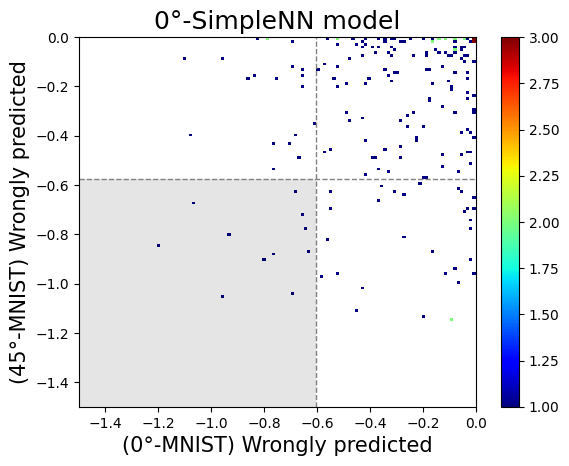

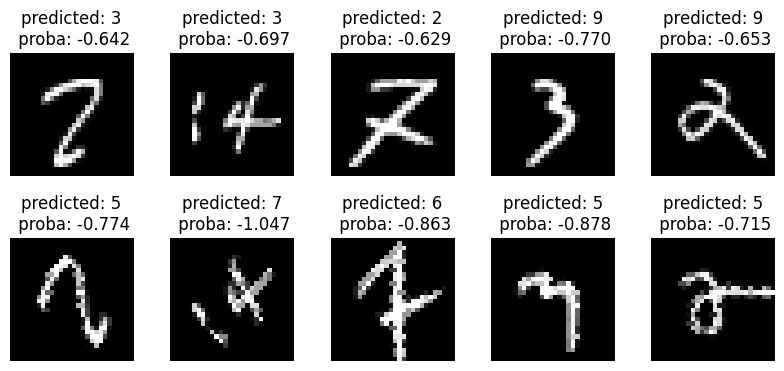

In [119]:
plot_mnist_examples(
    mask=mal_mal_preds,
    inputs_1=inputs_1, np_targets_1=np_targets_1, np_logits_1=np_logits_1, np_preds_1=np_preds_1,
    inputs_2=inputs_2, np_targets_2=np_targets_2, np_logits_2=np_logits_2, np_preds_2=np_preds_2,
    xcadrillage=50, ycadrillage=50,
    what='mal_mal_preds_logits',
    xlabel='Wrongly predicted', ylabel='Wrongly predicted',
    config=config)


#### misc tests

In [ ]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape
H, xedges, yedges = np.histogram2d(a,b,bins=200) #,range=histRange)

In [ ]:
print(xedges)

[-1.20373380e+00 -1.19771602e+00 -1.19169824e+00 -1.18568046e+00
 -1.17966268e+00 -1.17364490e+00 -1.16762712e+00 -1.16160934e+00
 -1.15559156e+00 -1.14957378e+00 -1.14355600e+00 -1.13753822e+00
 -1.13152044e+00 -1.12550266e+00 -1.11948488e+00 -1.11346711e+00
 -1.10744933e+00 -1.10143155e+00 -1.09541377e+00 -1.08939599e+00
 -1.08337821e+00 -1.07736043e+00 -1.07134265e+00 -1.06532487e+00
 -1.05930709e+00 -1.05328931e+00 -1.04727153e+00 -1.04125375e+00
 -1.03523597e+00 -1.02921819e+00 -1.02320041e+00 -1.01718263e+00
 -1.01116485e+00 -1.00514707e+00 -9.99129289e-01 -9.93111509e-01
 -9.87093730e-01 -9.81075950e-01 -9.75058170e-01 -9.69040390e-01
 -9.63022610e-01 -9.57004831e-01 -9.50987051e-01 -9.44969271e-01
 -9.38951491e-01 -9.32933711e-01 -9.26915932e-01 -9.20898152e-01
 -9.14880372e-01 -9.08862592e-01 -9.02844812e-01 -8.96827033e-01
 -8.90809253e-01 -8.84791473e-01 -8.78773693e-01 -8.72755914e-01
 -8.66738134e-01 -8.60720354e-01 -8.54702574e-01 -8.48684794e-01
 -8.42667015e-01 -8.36649

In [ ]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 3., 3.]])

In [ ]:
print(np_targets_1[(np.array(logits_1)<=xedges[50]) & (np.array(logits_2)<=yedges[50])])
print(np_preds_1[(np.array(logits_1)<=xedges[0]) & mal_mal_preds])

[8]
[8]


In [ ]:
def get_examples(test_loader):
    inpts, targets = [], []
    for inputs, labels in test_loader:

        inpts.extend(inputs)
        targets.extend(labels)

    return np.array(inpts, dtype=object), np.array(targets)

In [ ]:
inpts_1, trgts_1 = get_examples(test_loader_1['loader'])
inpts_2, trgts_2 = get_examples(test_loader_2['loader'])

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  


[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


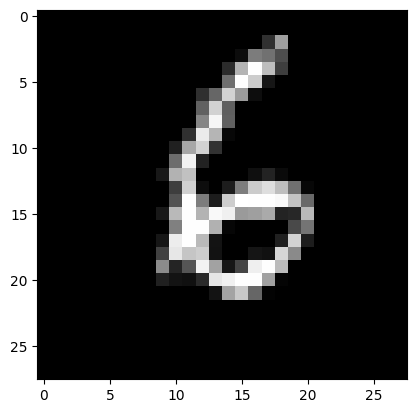

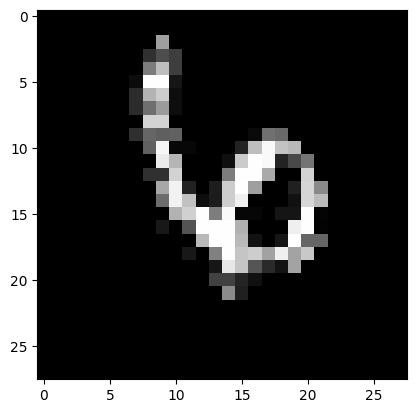

(195,)


In [ ]:
print(trgts_1)
print(trgts_2)

plt.imshow(inpts_1[2000][0], cmap='gray')
plt.show()
plt.imshow(inpts_2[2000][0], cmap='gray')
plt.show()


print(np.array(inpts_1)[mal_mal_preds].shape)

[8]
[7]
torch.Size([1, 28, 28])


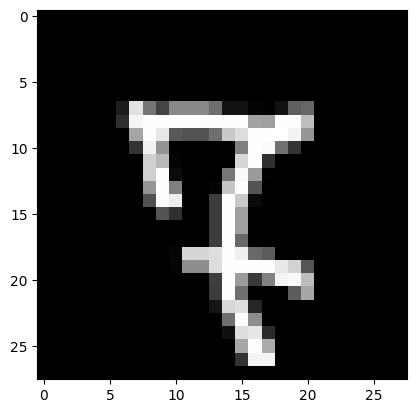

In [ ]:
cond = (np.array(logits_1)<=xedges[0]) & mal_mal_preds

print(np_preds_1[cond])
print(trgts_1[cond])

print(inpts_1[cond][0].shape)
plt.imshow(inpts_1[cond][0][0], cmap='gray')
plt.show()

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


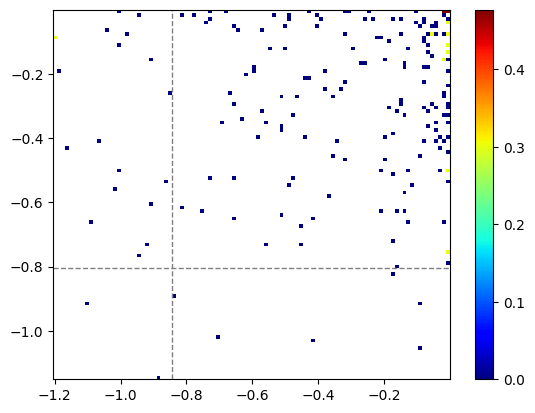

In [ ]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape


H, xedges, yedges = np.histogram2d(a,b,bins=100) #,range=histRange)

# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
# Log
#if log is True:
#    Hmasked = np.log10(Hmasked)     
Hmasked = np.log10(Hmasked)     

# Plot 2D histogram using pcolor
fig2 = plt.figure()
plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')  #, vmin=0, vmax=800)
plt.colorbar()
#plt.xticks(range(0,20,200), range(10))
#plt.yticks(range(10))

# Cadrillage
plt.axhline(y=yedges[30], linestyle='--', linewidth=1, color='grey')
plt.axvline(x=xedges[30], linestyle='--', linewidth=1, color='grey')

# plt.title('{}°-SimpleNN model'.format(deg_in), fontsize=18)
# plt.ylabel('({}°-MNIST) {}'.format(deg_in, ylabel), fontsize=15)
# plt.xlabel('({}°-MNIST) {}'.format(deg_out, xlabel), fontsize=15)
# path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_{}_{}deg_in_{}deg_out.pdf'.format(
#     deg_in,
#     what,
#     deg_in,
#     deg_out 
# )
# plt.savefig(path)
plt.show()

In [ ]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape

H, xedges, yedges = np.histogram2d(a,b,bins=100) #,range=histRange)

H[:30, :30]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

[8 5 5 8 5 8 0 5]
[7 8 9 7 9 6 2 3]
number of examples wrongly classified before and after rotation shift is (195,)


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


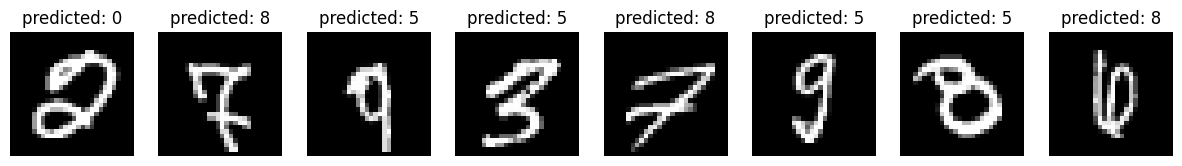

In [ ]:
a = np.array(logits_1)[mal_mal_preds]
b = np.array(logits_2)[mal_mal_preds]

assert a.shape==b.shape

H, xedges, yedges = np.histogram2d(a,b,bins=100) #,range=histRange)


cond_1 = (np.array(logits_1)<=xedges[30]) & mal_mal_preds
cond_2 = (np.array(logits_2)<=yedges[30]) & mal_mal_preds

print(np_preds_1[cond_1])
print(trgts_1[cond_1])
print(np.where(mal_mal_preds==True)[0])


plt.figure(figsize=(15, 3))

num_images = 8 
rng = np.random.default_rng()
images_and_labels = rng.choice(list(zip(inpts_1[cond_1], np_preds_1[cond_1])), size=num_images, replace=False)

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    img, pred = images_and_labels[i]
    plt.imshow(img[0], cmap='gray')
    plt.title(f'predicted: {pred}')
    plt.axis('off')

plt.show()

### tests on logits (not probabilities!)

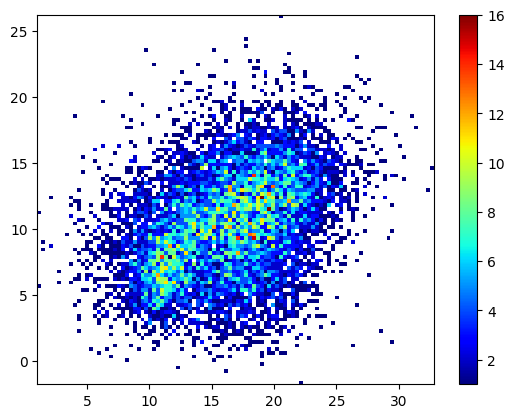

In [ ]:
H, xedges, yedges = np.histogram2d(np.array(logits_1),np.array(logits_2),bins=100) #,range=histRange)
#H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
#print(xedges, yedges)

# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
# Log
#Hmasked = np.log10(Hmasked)     

# Plot 2D histogram using pcolor
fig2 = plt.figure()
#plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
plt.colorbar()
#plt.xticks(range(0,20,200), range(10))
#plt.yticks(range(10))
plt.show()

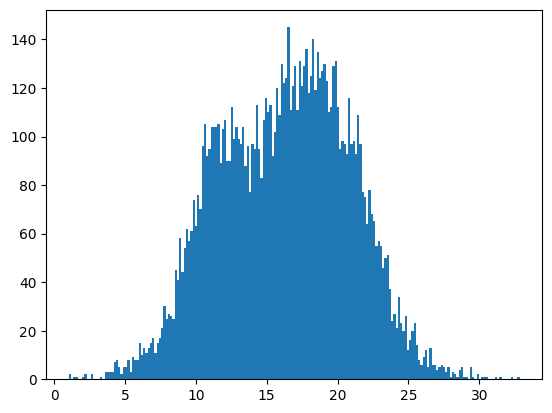

In [ ]:
plt.hist(np.array(logits_1), bins=200)
plt.show()